# 0. Initial imports and data loading

In [1]:
import math 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime
from meteostat import Point, Daily

import matplotlib.colors as colors
import matplotlib.cm as cm
import osmnx as ox
import networkx as nx

import geopandas as gpd
import shapely.geometry

pd.set_option('display.max_columns', None)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
project_dir = "."

In [4]:
df_merged_reduced =  pd.read_csv(f"{project_dir}/data/merged_reduced_data.csv", index_col=0)

In [5]:
df_merged_reduced.created_date = pd.to_datetime(df_merged_reduced.created_date)

# 1. Modeling

In [6]:
le = LabelEncoder()
df_merged_reduced['borough_encoded'] = le.fit_transform(df_merged_reduced['borough'].astype(str))
df_merged_reduced['location_type_encoded'] = le.fit_transform(df_merged_reduced['location_type'].astype(str))

In [7]:
features = [
  "month",
  "day_of_week",
  "hour",
  "latitude",
  "longitude",
  "location_type_encoded",
  "borough_encoded",
  "tavg",
  "prcp",
  "snow"
]

y = df_merged_reduced.complaint_type
X = df_merged_reduced[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## 1.1 Random Forest

In [8]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=15, min_samples_leaf=10, n_jobs=2)
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

                                precision    recall  f1-score   support

             Abandoned Vehicle       0.83      0.10      0.17     40331
                   Air Quality       0.90      0.29      0.44      6230
                  Animal-Abuse       0.94      0.04      0.08      5230
                     Appliance       0.00      0.00      0.00     13517
              Blocked Driveway       0.69      0.04      0.07    101088
                  Building/Use       0.36      0.12      0.18     11995
            Consumer Complaint       0.87      0.99      0.92     12039
                Curb Condition       0.83      0.00      0.00      3957
                  Damaged Tree       0.26      0.24      0.25     18030
                   Dead Animal       0.00      0.00      0.00      5828
               Dead/Dying Tree       0.83      0.00      0.00      6223
             Derelict Vehicles       0.28      0.68      0.39     27757
               Dirty Condition       0.42      0.77      0.54  

In [9]:
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
print(feature_imp_df)

                 Feature  Gini Importance
5  location_type_encoded         0.716813
3               latitude         0.079833
4              longitude         0.061957
2                   hour         0.060653
7                   tavg         0.034963
6        borough_encoded         0.017544
1            day_of_week         0.012162
0                  month         0.010083
8                   prcp         0.005377
9                   snow         0.000616


## 1.2 Hist Gradient Boosting Classifier

In [10]:
hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42
    )

hgb.fit(X_train, y_train)

predictions = hgb.predict(X_test)
print(classification_report(y_test, predictions))

                                precision    recall  f1-score   support

             Abandoned Vehicle       0.74      0.10      0.18     40331
                   Air Quality       0.81      0.27      0.40      6230
                  Animal-Abuse       0.45      0.04      0.08      5230
                     Appliance       0.30      0.00      0.00     13517
              Blocked Driveway       0.63      0.03      0.07    101088
                  Building/Use       0.28      0.18      0.22     11995
            Consumer Complaint       1.00      1.00      1.00     12039
                Curb Condition       0.57      0.28      0.38      3957
                  Damaged Tree       0.25      0.22      0.23     18030
                   Dead Animal       0.14      0.01      0.02      5828
               Dead/Dying Tree       0.13      0.07      0.09      6223
             Derelict Vehicles       0.31      0.57      0.40     27757
               Dirty Condition       0.47      0.69      0.55  

## 1.3 Logistic Regression

In [8]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [9]:
lr = make_pipeline(
  StandardScaler(), # Scale data for LogReg to work correctly
  LogisticRegression(max_iter=1000, n_jobs=2)
)

lr.fit(X_train, y_train)

predictions = lr.predict(X_test)
print(classification_report(y_test, predictions))

                                precision    recall  f1-score   support

             Abandoned Vehicle       0.00      0.00      0.00     40331
                   Air Quality       0.00      0.00      0.00      6230
                  Animal-Abuse       0.00      0.00      0.00      5230
                     Appliance       0.00      0.00      0.00     13517
              Blocked Driveway       0.22      0.01      0.01    101088
                  Building/Use       0.10      0.02      0.04     11995
            Consumer Complaint       1.00      0.00      0.00     12039
                Curb Condition       0.00      0.00      0.00      3957
                  Damaged Tree       0.21      0.04      0.06     18030
                   Dead Animal       0.00      0.00      0.00      5828
               Dead/Dying Tree       0.00      0.00      0.00      6223
             Derelict Vehicles       0.05      0.00      0.01     27757
               Dirty Condition       0.18      0.01      0.02  

# 2. Model improvement

In [10]:
# Define the mapping dictionary
complaint_mapping = {
    # --- 1. NOISE (The biggest category) ---
    'Noise - Residential': 'Noise',
    'Noise - Street/Sidewalk': 'Noise',
    'Noise - Commercial': 'Noise',
    'Noise - Vehicle': 'Noise',
    'Noise - Park': 'Noise',
    'Noise - Helicopter': 'Noise',
    'Noise - Unspecified': 'Noise',

    # --- 2. PARKING & VEHICLES (Enforcement) ---
    'Illegal Parking': 'Parking & Vehicles',
    'Blocked Driveway': 'Parking & Vehicles',
    'Abandoned Vehicle': 'Parking & Vehicles',
    'Derelict Vehicles': 'Parking & Vehicles',
    'For Hire Vehicle Complaint': 'Parking & Vehicles',
    'Car Service': 'Parking & Vehicles',
    
    # --- 3. HOUSING & BUILDINGS (Indoor/Residential) ---
    'Heat/Hot Water': 'Housing & Buildings',
    'Plumbing': 'Housing & Buildings',
    'General Construction/Plumbing': 'Housing & Buildings',
    'Paint/Plaster': 'Housing & Buildings',
    'Door/Window': 'Housing & Buildings',
    'Electric': 'Housing & Buildings',
    'Flooring/Stairs': 'Housing & Buildings',
    'Appliance': 'Housing & Buildings',
    'Elevator': 'Housing & Buildings',
    'Building/Use': 'Housing & Buildings',
    'Maintenance Or Facility': 'Housing & Buildings',
    'Unsanitary Condition': 'Housing & Buildings',
    'Indoor Air Quality': 'Housing & Buildings',
    'Safety': 'Housing & Buildings', # Usually refers to building safety

    # --- 4. STREETS & INFRASTRUCTURE (Outdoor/Physical) ---
    'Street Condition': 'Streets & Infrastructure',
    'Sidewalk Condition': 'Streets & Infrastructure',
    'Curb Condition': 'Streets & Infrastructure',
    'Root/Sewer/Sidewalk Condition': 'Streets & Infrastructure',
    'Street Light Condition': 'Streets & Infrastructure',
    'Traffic Signal Condition': 'Streets & Infrastructure',
    'Traffic': 'Streets & Infrastructure',
    'Snow Or Ice': 'Streets & Infrastructure',
    'Sewer': 'Streets & Infrastructure',
    'Water System': 'Streets & Infrastructure',
    'Water Leak': 'Streets & Infrastructure',
    'Standing Water': 'Streets & Infrastructure',

    # --- 5. SANITATION & DIRTY CONDITIONS ---
    'Dirty Condition': 'Sanitation',
    'Missed Collection': 'Sanitation',
    'Illegal Dumping': 'Sanitation',
    'Residential Disposal Complaint': 'Sanitation',
    'Street Sweeping Complaint': 'Sanitation',
    'Recycling Enforcement': 'Sanitation',

    # --- 6. PESTS & ANIMALS ---
    'Rodent': 'Pests & Animals',
    'Dead Animal': 'Pests & Animals',
    'Animal-Abuse': 'Pests & Animals',
    'Mosquitoes': 'Pests & Animals',

    # --- 7. TREES ---
    'Damaged Tree': 'Trees',
    'Dead/Dying Tree': 'Trees',
    'New Tree Request': 'Trees',
    'Overgrown Tree/Branches': 'Trees',

    # --- 8. PUBLIC SAFETY & ENFORCEMENT ---
    'Drug Activity': 'Public Safety',
    'Illegal Fireworks': 'Public Safety',
    'Graffiti': 'Public Safety',
    'Encampment': 'Public Safety',
    'Non-Emergency Police Matter': 'Public Safety',
    'Panhandling': 'Public Safety',
    'Vendor Enforcement': 'Public Safety',

    # --- 9. CONSUMER & OTHER ---
    'Consumer Complaint': 'Consumer & Other',
    'Food Establishment': 'Consumer & Other',
    'Lead': 'Consumer & Other', # Can be housing, but often separate health tracking
    'Air Quality': 'Consumer & Other',
    'Lost Property': 'Consumer & Other',
    'General': 'Consumer & Other',
    'Obstruction': 'Consumer & Other'
}

In [11]:
# 1. Apply the mapping
df_merged_reduced['target_grouped'] = df_merged_reduced['complaint_type'].map(complaint_mapping)

# 2. Check for any missing values (complaints that weren't in the list)
# If any appear as NaN, fill them with 'Other'
df_merged_reduced['target_grouped'] = df_merged_reduced['target_grouped'].fillna('Other')

# 3. Verify the new breakdown
print(df_merged_reduced['target_grouped'].value_counts())

target_grouped
Parking & Vehicles          1580473
Housing & Buildings         1486394
Noise                       1428957
Streets & Infrastructure     594632
Sanitation                   311154
Public Safety                280772
Consumer & Other             233169
Trees                        167083
Pests & Animals              118430
Name: count, dtype: int64


## 2.1 rerun model

In [12]:
features = [
  "month",
  "day_of_week",
  "hour",
  "latitude",
  "longitude",
  "location_type_encoded",
  "borough_encoded",
  "tavg",
  "prcp",
  "snow"
]

y = df_merged_reduced.target_grouped
X = df_merged_reduced[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [34]:
rf = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=15, min_samples_leaf=10, n_jobs=2, class_weight='balanced')
rf.fit(X_train, y_train)

predictions = rf.predict(X_test)
print(classification_report(y_test, predictions))

                          precision    recall  f1-score   support

        Consumer & Other       0.72      0.41      0.52     69525
     Housing & Buildings       0.89      0.88      0.89    445828
                   Noise       0.90      0.73      0.81    428747
      Parking & Vehicles       0.85      0.84      0.84    475436
         Pests & Animals       0.68      0.69      0.69     35563
           Public Safety       0.51      0.62      0.56     84205
              Sanitation       0.59      0.68      0.63     92944
Streets & Infrastructure       0.54      0.58      0.56    177907
                   Trees       0.35      0.90      0.50     50165

                accuracy                           0.76   1860320
               macro avg       0.67      0.70      0.67   1860320
            weighted avg       0.79      0.76      0.77   1860320



In [15]:
importances = rf.feature_importances_
feature_imp_df = pd.DataFrame({'Feature': features, 'Gini Importance': importances}).sort_values(
    'Gini Importance', ascending=False)
print(feature_imp_df)

                 Feature  Gini Importance
5  location_type_encoded         0.745973
3               latitude         0.074658
4              longitude         0.061146
2                   hour         0.047418
7                   tavg         0.020962
6        borough_encoded         0.020824
0                  month         0.012082
1            day_of_week         0.009934
8                   prcp         0.006540
9                   snow         0.000463


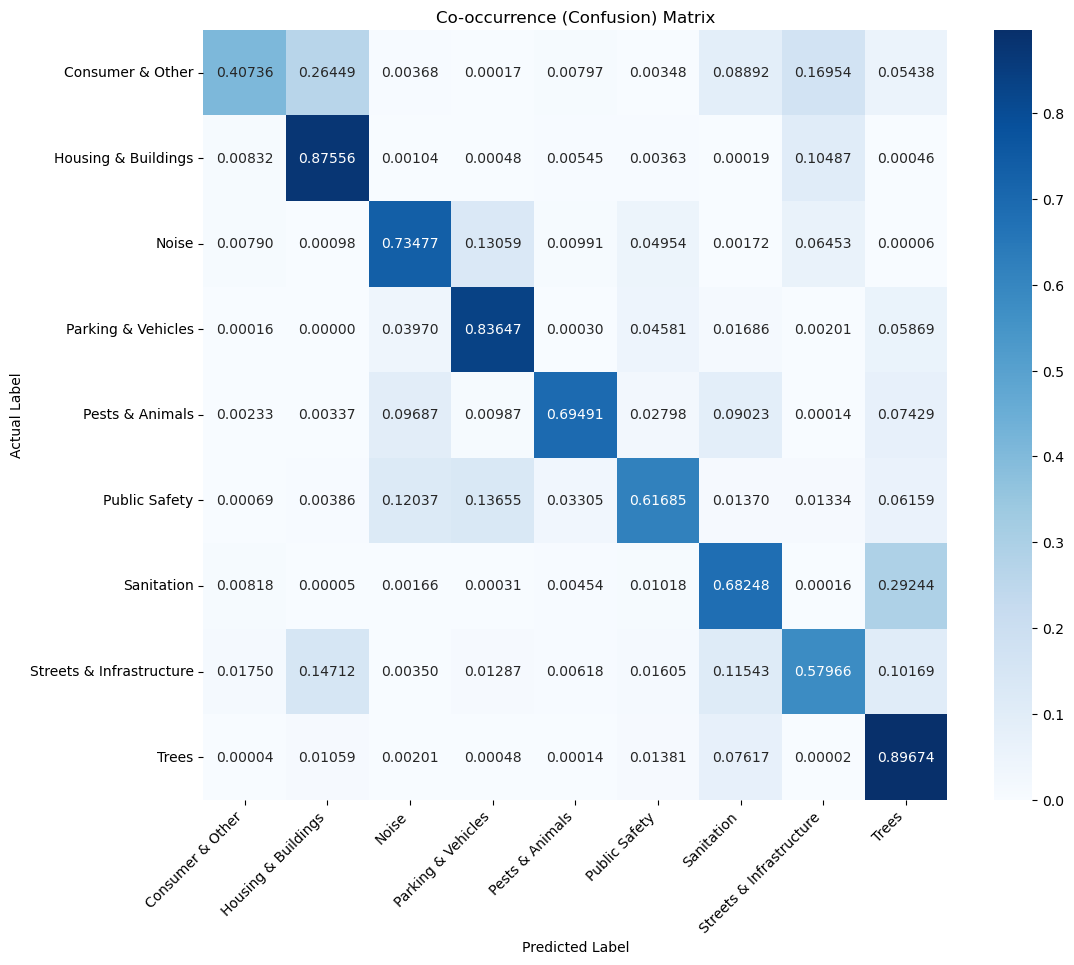

In [39]:
labels = [
    "Consumer & Other", 
    "Housing & Buildings", 
    "Noise", 
    "Parking & Vehicles", 
    "Pests & Animals", 
    "Public Safety", 
    "Sanitation", 
    "Streets & Infrastructure", 
    "Trees"
]

cm = confusion_matrix(y_test, predictions, labels=labels, normalize="true")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.5f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.title('Co-occurrence (Confusion) Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.show()

In [40]:
hgb = HistGradientBoostingClassifier(
        max_iter=100,
        random_state=42
    )

hgb.fit(X_train, y_train)

predictions = hgb.predict(X_test)
print(classification_report(y_test, predictions))

                          precision    recall  f1-score   support

        Consumer & Other       0.94      0.38      0.55     69525
     Housing & Buildings       0.89      0.90      0.89    445828
                   Noise       0.87      0.81      0.84    428747
      Parking & Vehicles       0.81      0.91      0.85    475436
         Pests & Animals       0.90      0.70      0.79     35563
           Public Safety       0.81      0.49      0.61     84205
              Sanitation       0.59      0.75      0.66     92944
Streets & Infrastructure       0.57      0.57      0.57    177907
                   Trees       0.45      0.66      0.53     50165

                accuracy                           0.79   1860320
               macro avg       0.76      0.69      0.70   1860320
            weighted avg       0.81      0.79      0.79   1860320



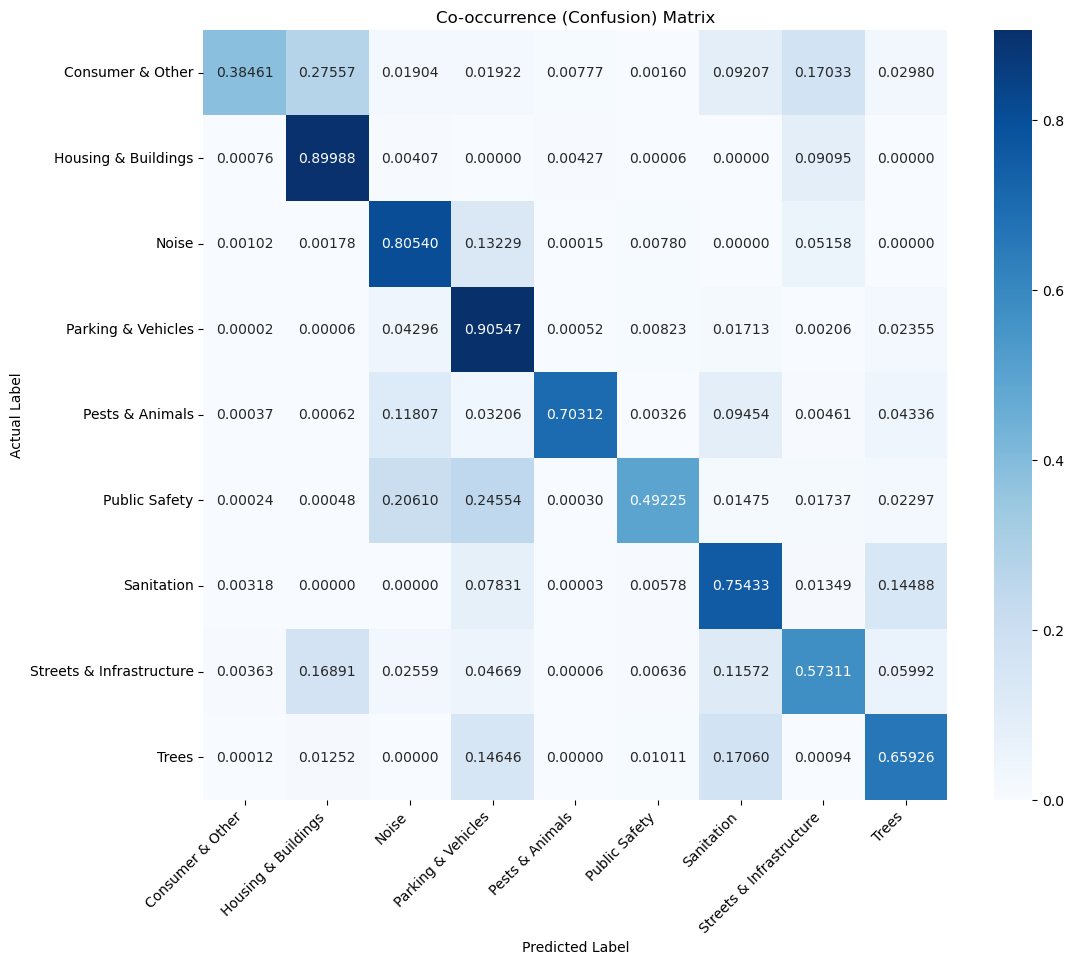

In [ ]:
cm = confusion_matrix(y_test, predictions, labels=labels, normalize="true")

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='.5f', cmap='Blues', 
            xticklabels=labels, yticklabels=labels)

plt.title('Co-occurrence (Confusion) Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.show()